# Model Diagnostics & Presentation Visuals

This notebook creates presentation-ready visualizations of model performance for the **Alberta Grid Balance Predictor**.

It expects (generated by your training pipeline):

- `data/processed/predictions.csv` (test timestamps, actual `balance_mw`, `y_pred`, `y_lower`, `y_upper`, `band`, recommendations)
- `data/processed/alberta_hourly_clean.csv` (cleaned features; used for feature importances fallback)
- `models/meta.json` (summary metrics and feature list)
- `models/regressor.joblib` or `models/regressor.keras` (optional — used for feature importances)
- `models/classifier.joblib` (optional)

If Keras training history was saved (e.g. `models/ann_history.json`) the notebook will also plot training/validation loss curves.

Run cells in order and use the resulting plots in your slides.

In [6]:
# Standard imports and plotting style
import sys
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.metrics import confusion_matrix
from matplotlib.ticker import FuncFormatter

sns.set_theme(style="whitegrid", context="talk")
PALETTE = sns.color_palette("muted")  # readable, presentation-friendly
plt.rcParams['figure.dpi'] = 110

In [9]:
# Paths
ROOT = Path(__file__).resolve().parents[1] if "__file__" in globals() else Path().resolve().parent
sys.path.append(str(ROOT / "src"))

PRED_PATH = ROOT / ("data/processed/predictions.csv")
CLEAN_PATH = ROOT / ("data/processed/alberta_hourly_clean.csv")
META_PATH = ROOT / ("models/meta.json")
REG_MODEL_PATH = ROOT / ("models/regressor.joblib")
KERAS_MODEL_PATH = ROOT / ("models/regressor.keras")
CLASS_MODEL_PATH = ROOT / ("models/classifier.joblib")
HISTORY_PATH = ROOT / ("models/ann_history.json")

# Load predictions (required)
if not PRED_PATH.exists():
    raise FileNotFoundError(f"Predictions file missing: {PRED_PATH}. Run the training pipeline first.")
df_pred = pd.read_csv(PRED_PATH, parse_dates=["timestamp"])
# Ensure timezone not required for plotting
df_pred['timestamp'] = pd.to_datetime(df_pred['timestamp'], errors="coerce", utc=True)
df_pred['timestamp'] = df_pred['timestamp'].dt.tz_convert("America/Edmonton").dt.tz_localize(None)

# Load cleaned data
df_clean = None
if CLEAN_PATH.exists():
    df_clean = pd.read_csv(CLEAN_PATH, parse_dates=["timestamp"])
    df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'], errors="coerce", utc=True)
    df_clean['timestamp'] = df_clean['timestamp'].dt.tz_convert("America/Edmonton").dt.tz_localize(None)


# Load meta.json if present
meta = {}
if META_PATH.exists():
    with open(META_PATH, "r") as f:
        meta = json.load(f)
else:
    print("Warning: models/meta.json not found. Some summary metrics will not be available.")

In [12]:
def plot_metric_cards(metrics_dict, width=1.2):
    """
    metrics_dict: ordered dict-like of label->(value, fmt)
    e.g. {"MAE": (1.88, "{:.2f} MW"), "RMSE": (6.11, "{:.2f} MW")}
    """
    n = len(metrics_dict)
    fig, axes = plt.subplots(1, n, figsize=(3.2*n, 2.2))
    if n == 1:
        axes = [axes]
    for ax, (label, (val, fmt)) in zip(axes, metrics_dict.items()):
        ax.axis("off")
        ax.text(0.5, 0.6, label, ha="center", va="center", fontsize=16, color="gray")
        ax.text(0.5, 0.25, fmt.format(val), ha="center", va="center", fontsize=22, fontweight="bold", color=PALETTE[0])
    plt.tight_layout()
    plt.show()

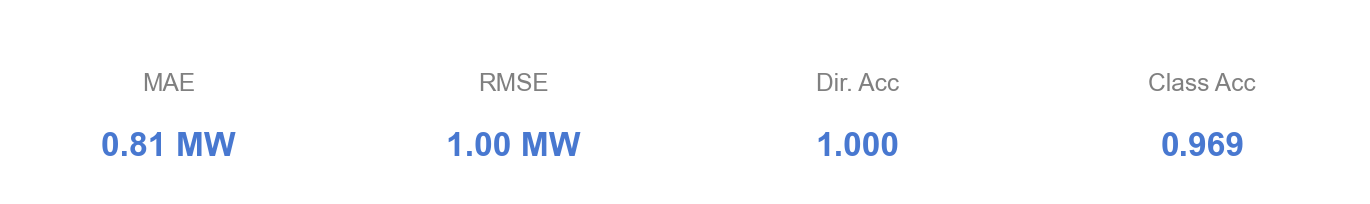

In [33]:
from collections import OrderedDict

# Gather metrics from meta.json if available; else compute from predictions where possible
reg_metrics = meta.get("regression_metrics", {})
clf_metrics = meta.get("classification_metrics", {})

# fallback: compute regression metrics from predictions.csv if meta missing
if not reg_metrics:
    y_true = df_pred['balance_mw'].values
    y_pred = df_pred['y_pred'].values
    mae = np.mean(np.abs(y_true - y_pred))
    rmse = np.sqrt(np.mean((y_true - y_pred)**2))
    dir_acc = (np.sign(y_true) == np.sign(y_pred)).mean()
    reg_metrics = {"mae": mae, "rmse": rmse, "dir_acc": dir_acc}

# fallback classification accuracy from meta (if not present, compute from band field assuming band is predicted)
if not clf_metrics:
    clf_metrics = {"accuracy": meta.get("classification_metrics", {}).get("accuracy", "N/A")}

card_metrics = OrderedDict([
    ("MAE", (reg_metrics.get("mae", float("nan")), "{:.2f} MW")),
    ("RMSE", (reg_metrics.get("rmse", float("nan")), "{:.2f} MW")),
    ("Dir. Acc", (reg_metrics.get("dir_acc", float("nan")), "{:.3f}")),
    ("Class Acc", (clf_metrics.get("accuracy", float("nan")), "{:.3f}"))
])

plot_metric_cards(card_metrics)

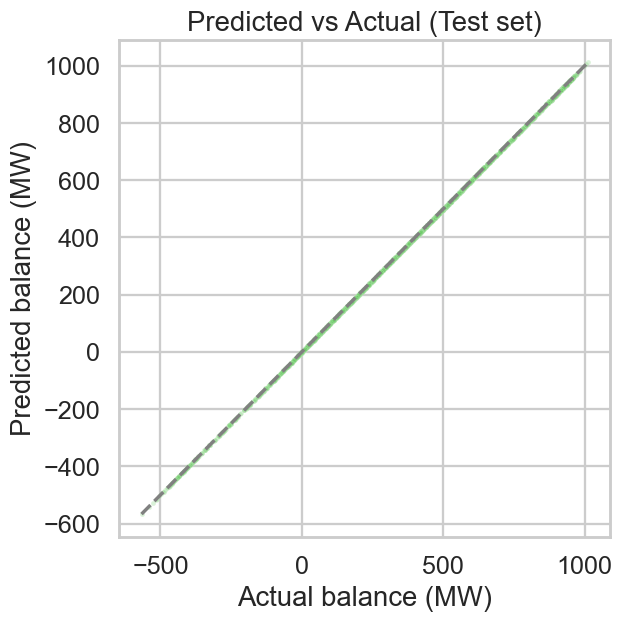

In [15]:
# Pred vs Actual scatter (all test rows)
y_true = df_pred['balance_mw']
y_pred = df_pred['y_pred']

plt.figure(figsize=(6,6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.25, s=10, color=PALETTE[2])
maxval = max(y_true.max(), y_pred.max())
minval = min(y_true.min(), y_pred.min())
plt.plot([minval, maxval], [minval, maxval], ls="--", color="gray")
plt.xlabel("Actual balance (MW)")
plt.ylabel("Predicted balance (MW)")
plt.title("Predicted vs Actual (Test set)")
plt.tight_layout()
plt.show()

In [ ]:
# Convert to datetime index
df_pred = df_pred.set_index('timestamp').sort_index()
# Default view: last 7 days (if dataset spans that)
try:
    last_ts = df_pred.index.max()
    start = last_ts - pd.Timedelta(days=7)
    sample = df_pred.loc[start:last_ts]
    plt.figure(figsize=(12,4))
    sample[['balance_mw','y_pred']].plot(figsize=(12,4), linewidth=2)
    plt.ylabel("MW")
    plt.title("Actual vs Predicted balance — last 7 days")
    plt.legend(["Actual", "Predicted"])
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("Could not plot last 7 days:", e)

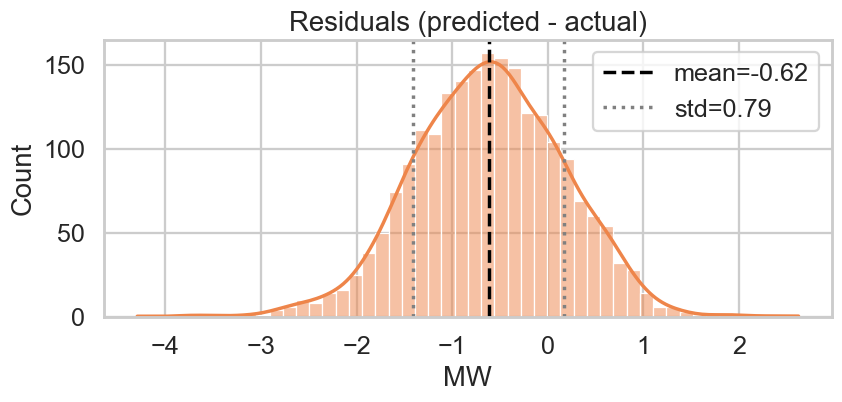

Residual mean: -0.617 MW, std: 0.788 MW, n=2160


In [24]:
resid = (df_pred['y_pred'] - df_pred['balance_mw']).dropna()
mu = resid.mean()
sigma = resid.std()

plt.figure(figsize=(8,4))
sns.histplot(resid, kde=True, color=PALETTE[1], bins=50)
plt.axvline(mu, color='black', linestyle='--', label=f"mean={mu:.2f}")
plt.axvline(mu+sigma, color='gray', linestyle=':', label=f"std={sigma:.2f}")
plt.axvline(mu-sigma, color='gray', linestyle=':')
plt.title("Residuals (predicted - actual)")
plt.xlabel("MW")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Residual mean: {mu:.3f} MW, std: {sigma:.3f} MW, n={len(resid)}")

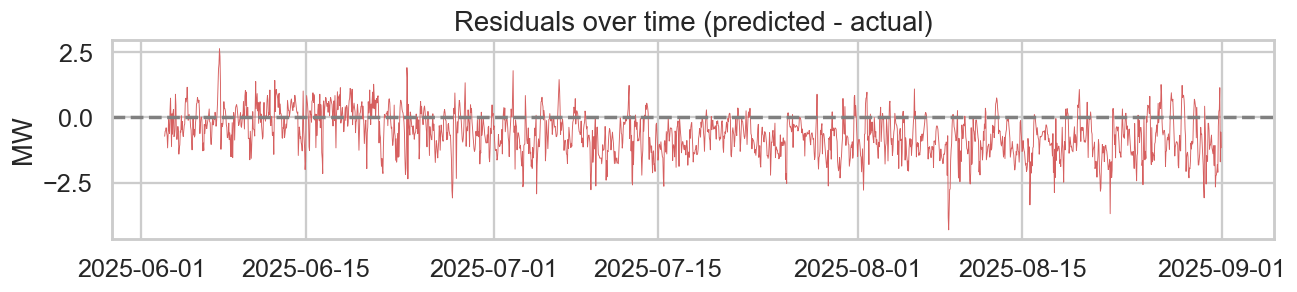

In [25]:
plt.figure(figsize=(12,3))
plt.plot(df_pred.index, resid, linewidth=0.6, color=PALETTE[3])
plt.axhline(0, color='gray', linestyle='--')
plt.title("Residuals over time (predicted - actual)")
plt.ylabel("MW")
plt.tight_layout()
plt.show()

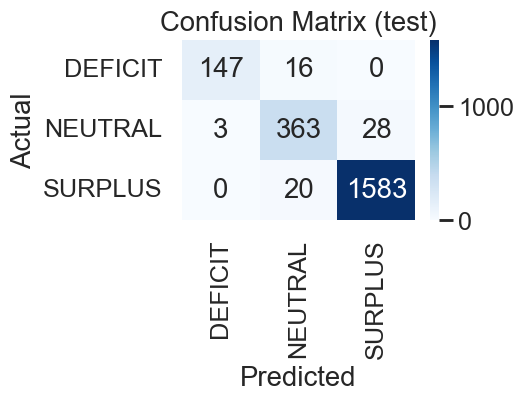

In [26]:
# If meta contains confusion matrix, use that; else try to compute from predictions (if you have true labels)
cm = None
labels = ["DEFICIT","NEUTRAL","SURPLUS"]  # mapping used in pipeline: 0,1,2
if "classification_metrics" in meta and "confusion_matrix" in meta["classification_metrics"]:
    cm = np.array(meta["classification_metrics"]["confusion_matrix"])
elif CLASS_MODEL_PATH.exists() and df_clean is not None:
    # Attempt to compute from classifier predictions if possible
    try:
        clf = joblib.load(CLASS_MODEL_PATH)
        # find features (meta['features']) and test set timestamps from predictions
        feat_list = meta.get("features", [])
        if feat_list and CLEAN_PATH.exists():
            # join cleaned features with predictions by timestamp
            test_ts = df_pred.reset_index()[['timestamp']].copy()
            df_clean_idx = df_clean.set_index('timestamp').reindex(pd.to_datetime(test_ts['timestamp'])).reset_index()
            X_test = df_clean_idx[feat_list]
            y_true_label = df_clean_idx.get('label', None)
            if y_true_label is not None:
                y_pred_label = clf.predict(X_test)
                cm = confusion_matrix(y_true_label, y_pred_label)
    except Exception as e:
        print("Could not compute confusion matrix from classifier:", e)

if cm is not None:
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix (test)")
    plt.tight_layout()
    plt.show()
else:
    print("Confusion matrix not available in meta and classifier-based computation failed/missing.")

C:\Users\Blood\AppData\Local\Temp\ipykernel_31032\1961827427.py:5: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  sns.barplot(x=band_counts.index, y=band_counts.values, palette=PALETTE, hue=band_counts.index, legend=False)


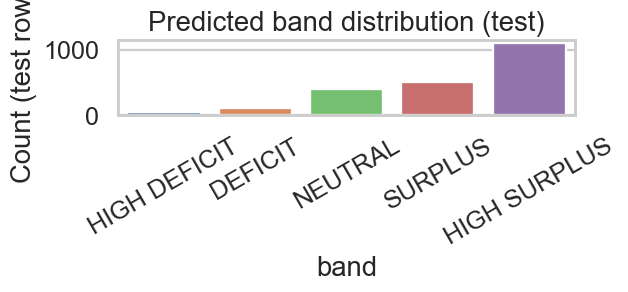

In [28]:
# Use 'band' field if present in predictions.csv (predicted band)
if 'band' in df_pred.columns:
    band_counts = df_pred['band'].value_counts().reindex(["HIGH DEFICIT","DEFICIT","NEUTRAL","SURPLUS","HIGH SURPLUS"]).fillna(0)
    plt.figure(figsize=(6,3))
    sns.barplot(x=band_counts.index, y=band_counts.values, palette=PALETTE, hue=band_counts.index, legend=False)
    plt.xticks(rotation=30)
    plt.ylabel("Count (test rows)")
    plt.title("Predicted band distribution (test)")
    plt.tight_layout()
    plt.show()
else:
    print("No 'band' column in predictions.csv to show class distribution.")

In [29]:
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler

def plot_feature_importance_from_model(model, feat_names, X_test, n_top=15):
    # Try model.feature_importances_ or coef_ first
    fi = None
    if hasattr(model, "feature_importances_"):
        fi = np.array(model.feature_importances_)
    elif hasattr(model, "coef_"):
        fi = np.abs(np.ravel(model.coef_))
    if fi is not None and len(fi) == len(feat_names):
        idx = np.argsort(fi)[::-1][:n_top]
        plt.figure(figsize=(8,4))
        sns.barplot(x=fi[idx], y=np.array(feat_names)[idx], palette=PALETTE)
        plt.xlabel("Importance")
        plt.title("Feature importances")
        plt.tight_layout()
        plt.show()
        return True
    return False

if REG_MODEL_PATH.exists() and meta.get("features") and df_clean is not None:
    try:
        model = joblib.load(REG_MODEL_PATH)
        feat_list = meta['features']
        # Build X_test by aligning predictions timestamps to cleaned df
        test_ts = df_pred.reset_index()[['timestamp']].copy()
        dfc_idx = df_clean.set_index('timestamp').reindex(pd.to_datetime(test_ts['timestamp'])).reset_index()
        # ensure feat columns exist
        if all(f in dfc_idx.columns for f in feat_list):
            X_test = dfc_idx[feat_list].fillna(0)
            y_test = dfc_idx['balance_mw'].values
            # try direct feature_importances_ or coef_
            ok = plot_feature_importance_from_model(model, feat_list, X_test)
            if not ok:
                # fallback to permutation importance (may take time)
                print("Computing permutation importance (this may take a little while)...")
                # scale if model expects scaled inputs
                scaler = StandardScaler()
                X_test_s = scaler.fit_transform(X_test)
                res = permutation_importance(model, X_test_s, y_test, n_repeats=8, random_state=42, n_jobs=-1, scoring='neg_mean_squared_error')
                imp_means = res.importances_mean
                idx = np.argsort(imp_means)[::-1][:15]
                plt.figure(figsize=(8,4))
                sns.barplot(x=imp_means[idx], y=np.array(feat_list)[idx], palette=PALETTE)
                plt.xlabel("Permutation importance (neg MSE)")
                plt.title("Permutation Feature Importance (top 15)")
                plt.tight_layout()
                plt.show()
        else:
            print("Some feature columns listed in meta are not present in cleaned data; cannot compute feature importance.")
    except Exception as e:
        print("Could not load regressor or compute feature importance:", e)
elif KERAS_MODEL_PATH.exists():
    print("A Keras regressor exists, but direct feature importances are not available. Consider using permutation importance (requires a saved training scaler and feature list).")
else:
    print("Regressor model not found (models/regressor.joblib or .keras). Skipping feature importance.")

Could not load regressor or compute feature importance: cannot reindex on an axis with duplicate labels


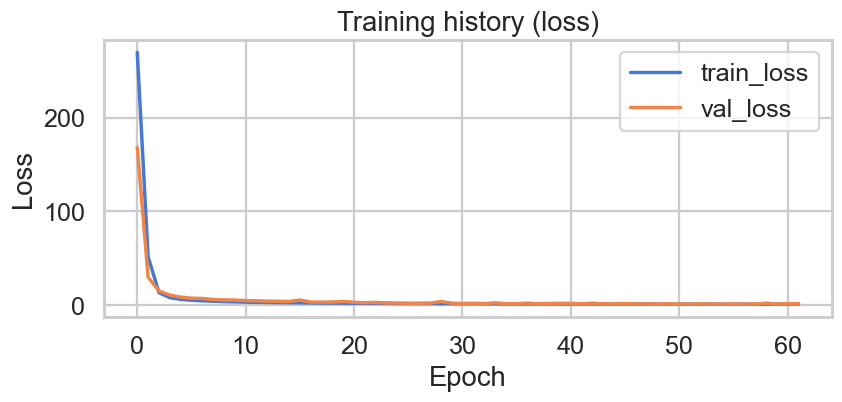

In [36]:
if HISTORY_PATH.exists():
    with open(HISTORY_PATH, "r") as f:
        hist = json.load(f)
    # hist expected keys: loss, val_loss (and maybe val_mae, etc)
    plt.figure(figsize=(8,4))
    if "loss" in hist:
        plt.plot(hist["loss"], label="train_loss", color=PALETTE[0])
    if "val_loss" in hist:
        plt.plot(hist["val_loss"], label="val_loss", color=PALETTE[1])
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training history (loss)")
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("No training history file found at models/ann_history.json. If you'd like training curves, save `history.history` after `.fit()` using JSON.")
    print("Example code to save history in training script:\n")
    print("""# after model.fit(...)
import json
with open('models/ann_history.json','w') as f:
    json.dump(history.history, f)""")